In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power
sns.set_theme()

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 13 апреля 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [2]:
df = pd.read_csv('user_transactions.csv')
df['event_date']=df.event_date.apply(date_converter)

#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.

In [3]:
df.head()

,event_date,user_id,product,amount,transactions
0,2020-09-29,40746820883461494,basic,95.0,1
1,2020-09-29,41102328408008828,advanced,279.0,1
2,2020-09-29,63464894315144075,basic,64.0,1
3,2020-09-29,111526991873455341,basic,399.0,1
4,2020-09-29,169522572963414231,basic,199.0,1


In [4]:
print(df.event_date.min(), df.event_date.max())

2020-09-29 00:00:00 2020-12-29 00:00:00


In [5]:
df['product'].value_counts()

basic       990428
advanced    287758
Name: product, dtype: int64

In [6]:
df.groupby(['user_id']).count().shape[0]

446935

In [7]:
print(f"Number of users using both products {df.groupby(['user_id', 'product']).count().shape[0] - df.groupby(['user_id']).count().shape[0]}")

Number of users using both products 31519


In [8]:
(df.groupby(['user_id', 'product']).count().shape[0] - df.groupby(['user_id']).count().shape[0]) / df.groupby(['user_id']).count().shape[0]

0.0705225592088335

##### Видим, что есть юзеры, которые пользуются обоими планами, их ~7%

#### Метрики, которые хочу считать

- Покупки на пользователя 
- Транзакции на пользователя 
- Средний чек на пользователя 
- Доля транзакций по вариантам продукта 

In [9]:
df_by_users = df.groupby(['user_id', 'product']).sum()

In [10]:
df_by_users = df_by_users.reset_index()

In [11]:
df_by_users['avg_check'] =  df_by_users.amount / df_by_users.transactions
df_by_users = df_by_users.rename(columns={'amount': 'amount_by_user', 'transactions': 'transactions_by_user'})
df_by_users

,user_id,product,amount_by_user,transactions_by_user,avg_check
0,1809139296429,advanced,980.0,1,980.000
1,1912219714366,basic,300.0,3,100.000
2,23708868092799,basic,1094.0,16,68.375
3,45305541518475,basic,158.0,2,79.000
4,51991933272698,basic,199.0,2,99.500
...,...,...,...,...,...
478449,9223341083512664945,basic,89.0,1,89.000
478450,9223348554567144516,basic,30.0,1,30.000
478451,9223353766165032250,basic,36.0,1,36.000
478452,9223361693694781577,basic,79.0,1,79.000


#### Пропорции пользоваетелй по продуктам


In [12]:
df_by_users['product'].value_counts() / df_by_users.shape[0]

basic       0.751479
advanced    0.248521
Name: product, dtype: float64

In [13]:
df_by_users.groupby(['product']).sum().transactions_by_user / df_by_users.transactions_by_user.sum()

product
advanced    0.222638
basic       0.777362
Name: transactions_by_user, dtype: float64

In [14]:
df_sum_by_date = df.groupby(['event_date']).sum()

##### Общие покупки на пользователя 

mean: 639.7203033102451 std: 3771.990951006972


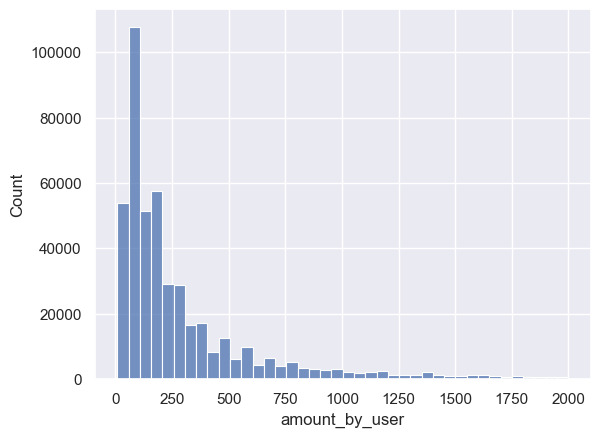

In [15]:
df.amount.quantile(0.975)
_ = sns.histplot(df_by_users.query("amount_by_user < 2000").amount_by_user, bins=40)
print('mean:',df_by_users.amount_by_user.mean(),'std:', df_by_users.amount_by_user.std())

mean: 3.4534103591985854 std: 15.072372274460749


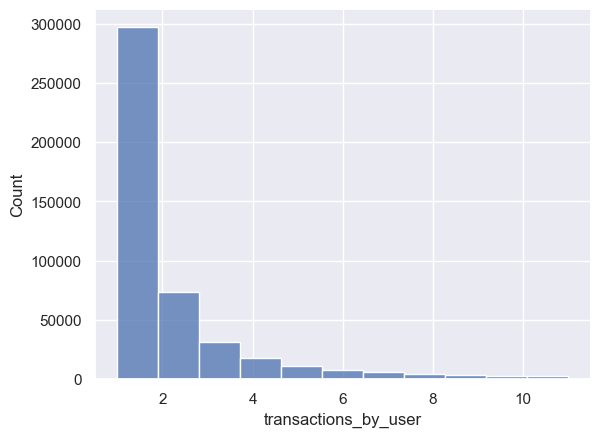

In [16]:
df.amount.quantile(0.975)
_ = sns.histplot(df_by_users.query("transactions_by_user < 12").transactions_by_user, bins=11)
print('mean:', df_by_users.transactions_by_user.mean(),'std:', df_by_users.transactions_by_user.std())

##### Выручка по датам 

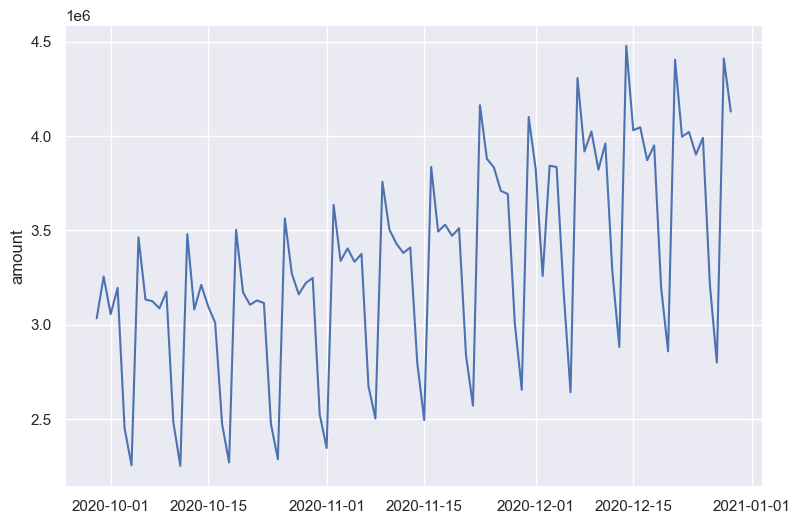

In [17]:
fig = plt.figure(figsize=(9, 6))
_ = plt.plot(df_sum_by_date.index, df_sum_by_date['amount'])
_ = plt.ylabel('amount')

##### Транзакции по датам 

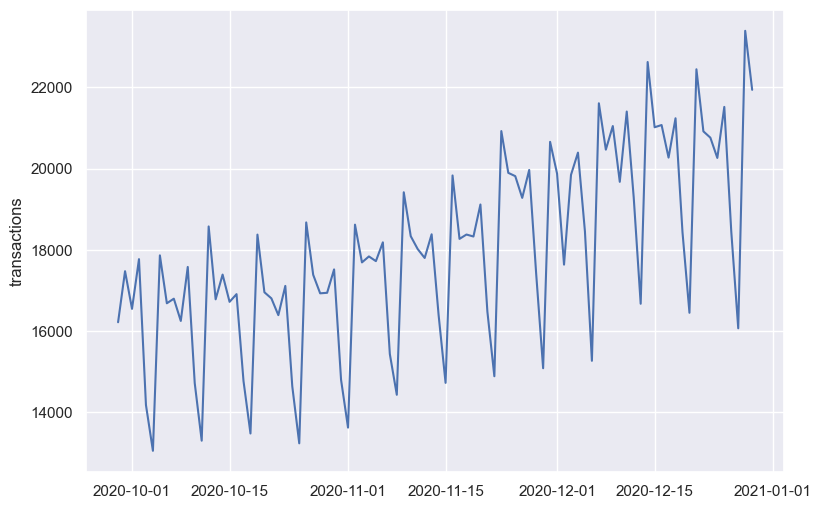

In [18]:
fig = plt.figure(figsize=(9, 6))
_ = plt.plot(df_sum_by_date.index, df_sum_by_date['transactions'])
_ = plt.ylabel('transactions')

##### Количество уникалых пользоваетелей 

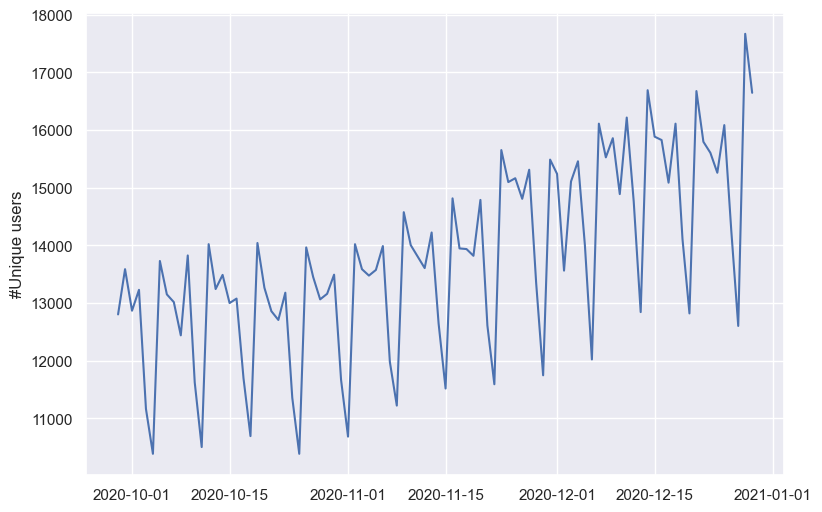

In [19]:
df_unique_users_by_date = df[['event_date', 'user_id']].groupby(['event_date']).nunique()

fig = plt.figure(figsize=(9, 6))
_ = plt.plot(df_unique_users_by_date.index, df_unique_users_by_date.user_id)
_ = plt.ylabel('#Unique users')


##### Так как количество пользователей больше в конце, чем в начале то наверное будет логичнее прогонять подбор времени эксперимента беря недели с конца

#### Видим что есть недельная сезональность, значит время проведения эксперимента будем подбирать кратно неделям и положительный тренд

#### Покупки на пользователя

Basic mean: 451.77217506424734 std: 2065.07237310183
Advanced mean: 1208.0379123004727 std: 6627.647361602047


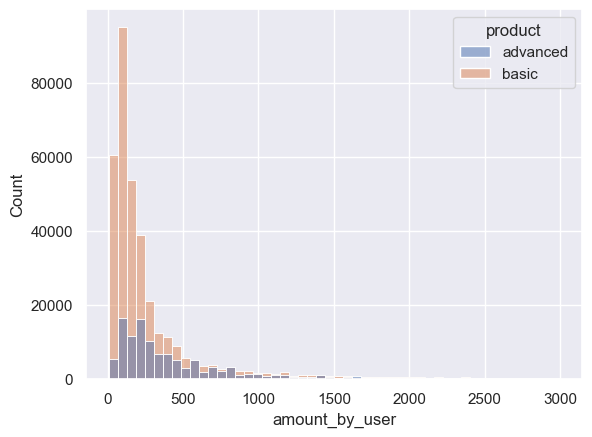

In [20]:
sns.histplot(data=df_by_users.query("amount_by_user < 3000"), x="amount_by_user", hue="product", bins=50)

print('Basic mean:', df_by_users.query("product == 'basic'").amount_by_user.mean(), 'std:', df_by_users.query("product == 'basic'").amount_by_user.std())
print('Advanced mean:',df_by_users.query("product == 'advanced'").amount_by_user.mean(),'std:', df_by_users.query("product == 'advanced'").amount_by_user.std())

##### Среднее в продукте advanced выше, и дисперсия больше

#### Транзакции на пользователя

Basic mean: 3.5723547342774817 std: 15.20525642037066
Advanced mean: 3.0937463206230134 std: 14.657424716538861


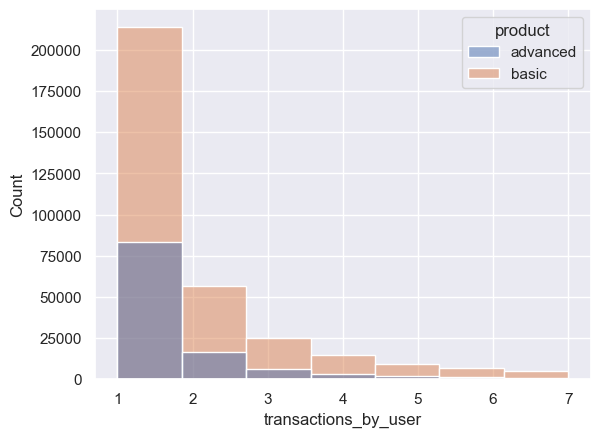

In [21]:
sns.histplot(data=df_by_users.query("transactions_by_user < 8"), x="transactions_by_user", hue="product", bins=7)\

print('Basic mean:', df_by_users.query("product == 'basic'").transactions_by_user.mean(), 'std:', df_by_users.query("product == 'basic'").transactions_by_user.std())
print('Advanced mean:',df_by_users.query("product == 'advanced'").transactions_by_user.mean(),'std:', df_by_users.query("product == 'advanced'").transactions_by_user.std())

##### Среднее в продукте basic выше, и дисперсия больше

#### Средний чек на пользователя

Basic mean: 118.7768699446482 std: 78.42234881385596
Advanced mean: 323.2353234906822 std: 257.09464774427005


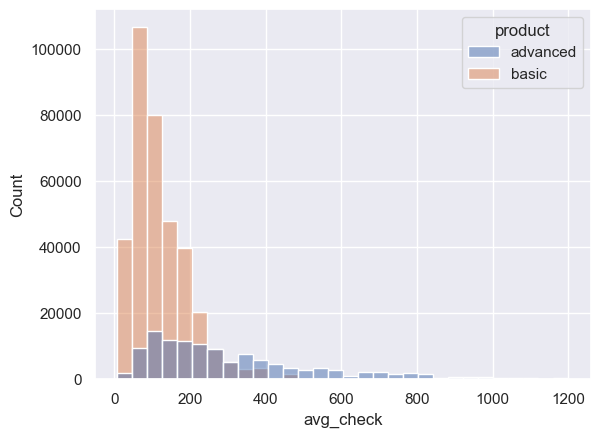

In [22]:
sns.histplot(data=df_by_users.query("avg_check < 1200"), x="avg_check", hue="product", bins=30)

print('Basic mean:', df_by_users.query("product == 'basic'").avg_check.mean(), 'std:', df_by_users.query("product == 'basic'").avg_check.std())
print('Advanced mean:',df_by_users.query("product == 'advanced'").avg_check.mean(),'std:', df_by_users.query("product == 'advanced'").avg_check.std())

##### Среднее в продукте advanced выше, и дисперсия больше

### В данных есть выбросы

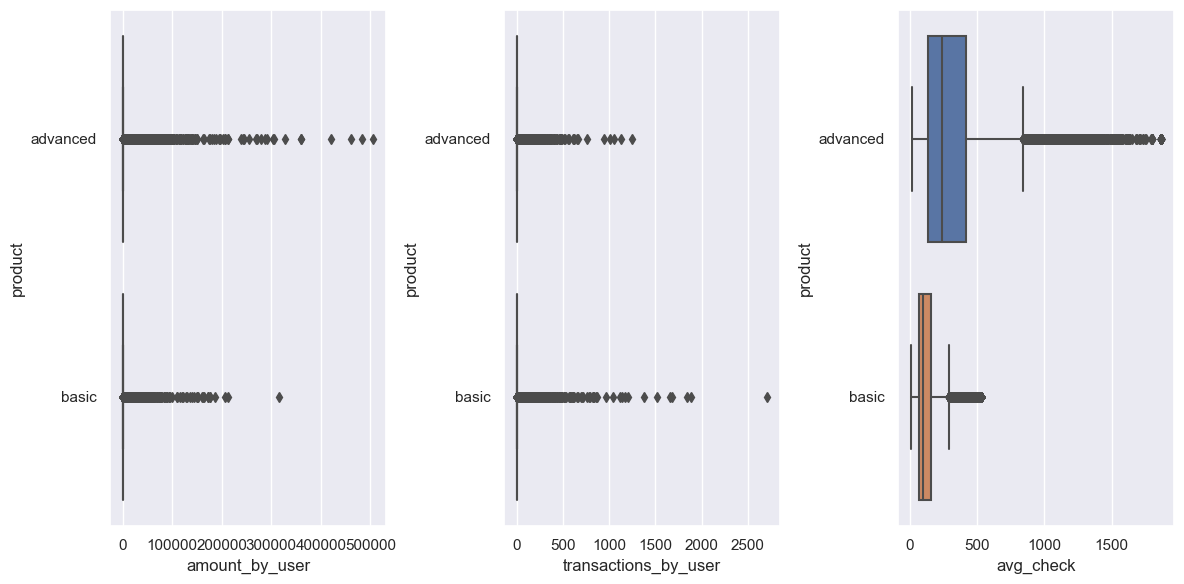

In [23]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))


sns.boxplot(data=df_by_users, x='amount_by_user', y='product', ax=ax1)
sns.boxplot(data=df_by_users, x='transactions_by_user', y='product', ax=ax2)
sns.boxplot(data=df_by_users, x='avg_check', y='product', ax=ax3)
fig.tight_layout()

### Формализация гипотез

Первая гипотеза : Дополнительное информирование об эффективности услуг будет стимулировать их покупку

- Число транзакций на пользователя должно увеличиться $\Rightarrow$ доходы на пользователя должны увеличиться, средний чек не особо информативен 
- Относительное MDE пусть везде будет по 5 процентов

Вторая гипотеза : Повышение цены базового продукта должно стимулировать покупку продвинутого продукта

- Доля пользователей в продукте advanced должна увеличиться, при этом мы не хотим сильно просадить количество транзакций и доходы на пользователя в продукте basic
- Здесь средний чек тоже не информативен
- Поставим также относительное MDE в 5 процентов

In [37]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=int(100*share)].reset_index()
    return x

#### Доходы на пользователя

In [26]:
x1 =choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 7 * 12, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

1.59612913297389


#### Получаем, что в квартал не уложимся если будем брать высоко-тратящих пользователей 

In [116]:
x1 =choose_date(df[df.amount < df.amount.quantile(0.995)], datetime.datetime(2020, 9, 29, 0, 0), 7 * 1, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

0.9307565607403077


#### Если уберем выше 0.995 квантиля, то уложимся в неделю

#### Транзакции на пользователя

In [77]:
x1 =choose_date(df,  datetime.datetime(2020, 9, 29, 0, 0), 7 * 8, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

0.9934176242537296


##### Уложимся только в 8 недель

In [95]:
x1 =choose_date(df[df.transactions < df.transactions.quantile(0.995)], datetime.datetime(2020, 9, 29, 0, 0), 7 * 1, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

0.39819453490254086


#### Здесь такая же ситуация

### Итого 1 неделя на эксперимент

### Повышение цены базового продукта должно стимулировать покупку продвинутого продукта

#### Доля пользующихся advanced

In [35]:
def choose_dates_for_prop(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id', 'product']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=int(100*share)].reset_index()
    return x

In [101]:
x1 =choose_dates_for_prop(df, datetime.datetime(2020, 9, 29, 0, 0), 7 * 1, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1['product'].map({'basic': 0, 'advanced': 1}).mean()
std = x1['product'].map({'basic': 0, 'advanced': 1}).std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

0.9316611333290126


##### Метрика чувствительная укладываемся в неделю, но скорее всего нужно будет ждать больше, чтобы пользователи решились перейти с одного тарифа на другой 

In [127]:
x1 =choose_dates_for_prop(df, datetime.datetime(2020, 9, 29, 0, 0), 7 * 1, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1['product'].map({'basic': 0, 'advanced': 1}).mean()
std = x1['product'].map({'basic': 0, 'advanced': 1}).std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

0.9316611333290126


#### Количество транзакций на пользователя в группе basic

In [118]:
df_basic = df.query("product == 'basic'")
x1 =choose_date(df_basic, datetime.datetime(2020, 9, 29, 0, 0), 7 * 12, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

1.0127796496050059


#### За квартал не успеем, если будем брать всех

In [130]:
df_basic = df.query("product == 'basic'")
x1 =choose_date(df_basic[df_basic.transactions < df_basic.transactions.quantile(0.995)], datetime.datetime(2020, 9, 29, 0, 0), 7 * 1, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

0.43449804987230956


#### Доходы на пользователя в группе basic

In [122]:
df_basic = df.query("product == 'basic'")
x1 =choose_date(df_basic, datetime.datetime(2020, 9, 29, 0, 0), 7 * 12, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

1.2408785452797257


In [121]:
df_basic = df.query("product == 'basic'")
x1 =choose_date(df_basic[df_basic.amount < df_basic.amount.quantile(0.995)], datetime.datetime(2020, 9, 29, 0, 0), 7 * 1, 0.5) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

0.6269561816414958


#### Такая же ситуация

### Итого 1 неделя на эксперимент

## Можем ли мы параллельно проверять две гипотезы? 

In [134]:
x1 =choose_dates_for_prop(df, datetime.datetime(2020, 9, 29, 0, 0), 7 * 3, 0.25) #получаем необходимую подвыборку
from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1['product'].map({'basic': 0, 'advanced': 1}).mean()
std = x1['product'].map({'basic': 0, 'advanced': 1}).std()
 
alpha = 0.01
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect

num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

print(num_obs / x1.shape[0])

0.8005013116719316


#### Получаем что нужно 3 недели для метрики доли пользователей, значит лучше проводить их по очереди, уложимся за 2 недели 

#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?